In [595]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier # Load k-NN from sklearn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import datetime as dt


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from mlens.ensemble import SuperLearner
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import auc, precision_recall_curve
from category_encoders.binary import BinaryEncoder



In [596]:
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column])
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [597]:
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    #sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues',annot_kws={"size": 16})
    plt.tight_layout()
    #plt.xlabel("Predicted label")
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.ylabel("Real label")
    plt.figure(figsize = (10,7))
    plt.show()

# Loading datasets

In [598]:
main_df2 = pd.read_csv('all_diagnoses.csv')
vitals_df = pd.read_csv("vitals_df.csv")
severity_scores_df = pd.read_csv('severity_scores_df.csv')

In [599]:
main_df2.shape

(968526, 21)

In [600]:
vitals_df.shape

(26106, 27)

In [601]:
severity_scores_df=severity_scores_df.drop_duplicates(subset='subject_id',keep='first').sort_values(by='subject_id')

In [602]:
# Removing redundant columns Subject_ID and HADM_ID
severity_scores_df = severity_scores_df.drop(['subject_id','hadm_id','hospital_expire_flag','ICUSTAY_AGE_GROUP',
                                              'OASIS', 'OASIS_PROB','age_score','preiculos_score', 'gcs_score',
                                                'heartrate_score', 'meanbp_score',
                                               'resprate_score', 'temp_score',
                                               'UrineOutput_score', 'mechvent_score',
                                               'electivesurgery_score', 'SAPS', 'resp_score', 'vent_score',
                                               'hematocrit_score', 'glucose_score', 'SAPSII', 'SAPSII_PROB',
                                               'PaO2FiO2_score', 'bilirubin_score', 'comorbidity_score',
                                               'admissiontype_score', 'SOFA','INTIME','age'], axis=1) 
#icustay_expire_flag

# Pre-Processing

**This part here will be commented out since this takes some time to run and has been saved out for computational reasons**

## Top 50 Diagnoses & Interactions

In [603]:
#from itertools import combinations

#def check_interactions(data,diagnoses):
#    #a = ["Single lb in-hosp w/o cs","Crnry athrscl natve vssl"]
#    count_all = []
#    count_deaths_all = []
#    combo1 = []
#    combo2 = []
#    icu_ids = []
#    for i,j in combinations(diagnoses, 2):
#        count = 0
#        count_deaths = 0
#        print(i,j)
#        icu_i = data['ICUSTAY_ID'][data['SHORT_TITLE'] == i].unique()
#        icu_j = data['ICUSTAY_ID'][data['SHORT_TITLE'] == j].unique()
#        both = [value for value in icu_i if value in icu_j]
        
#        for icu_stay in both:
#            data_subset = data[data['ICUSTAY_ID'] == icu_stay]
#            count += 1
#            count_deaths += [i for i in data_subset['HOSPITAL_EXPIRE_FLAG']][0] #data_subset['HOSPITAL_EXPIRE_FLAG'].to_list()[0] 
#        print(count_deaths)
#        print(count)
#        combo1.append(i)
#        combo2.append(j)
#        count_all.append(count)
#        count_deaths_all.append(count_deaths)
#        icu_ids.append(both)
#    return combo1, combo2, count_all, count_deaths_all, icu_ids

In [604]:
#deathrate = []
#count_deaths_list = []

#for condition in main_df2['SHORT_TITLE'].unique():
#    subset = main_df2[main_df2['SHORT_TITLE']==condition]
#    count = subset.shape[0]
#    count_deaths = subset['HOSPITAL_EXPIRE_FLAG'].sum()
#    deathrate.append(count_deaths/count)
#    count_deaths_list.append(count_deaths)

In [605]:
#deathrate_df = pd.DataFrame()
#deathrate_df['SHORT_TITLE'] = main_df2['SHORT_TITLE'].unique()
#deathrate_df['DEATHRATE'] = deathrate
#deathrate_df['PATIENT_COUNT'] = count_deaths_list
#deathrate_df_sorted = deathrate_df.sort_values(by='DEATHRATE',ascending=False)
#deathrate_df_sorted_top=deathrate_df_sorted[deathrate_df_sorted["PATIENT_COUNT"]>=10]

In [606]:
#dr_df = deathrate_df_sorted_top.copy()
#dr_df.loc[(dr_df['DEATHRATE'] >= 0.7), 'DEATHRATE_CAT'] = 2
#dr_df.loc[(dr_df['DEATHRATE'] < 0.7) & (dr_df['DEATHRATE'] >= 0.5), 'DEATHRATE_CAT'] = 1
#dr_df.loc[(dr_df['DEATHRATE'] < 0.5), 'DEATHRATE_CAT'] = 0

In [607]:
#top50_diagn = dr_df[dr_df["PATIENT_COUNT"]>=10].head(50)['SHORT_TITLE']
#combo1, combo2, count_all, count_deaths_all, icu_ids = check_interactions(main_df2,top50_diagn)

In [608]:
#interactions_df = pd.DataFrame()
#interactions_df['diagnosis1']=combo1
#interactions_df['diagnosis2']=combo2
#interactions_df['total_count']=count_all
#interactions_df['death_count']=count_deaths_all
#interactions_df['icu_ids'] = icu_ids
#death_rate=[]
#for i,j in zip(count_deaths_all,count_all):
#    if j!=0:
#        death_rate.append(i/j)
#    else:
#        death_rate.append(0)
#interactions_df['death_rate']=death_rate 
#interactions_df= interactions_df[interactions_df['total_count']>=10].sort_values(by='death_rate', ascending=False)

## Join first Diagnosis with individual diagnosis deathrates
#df_comp = interactions_df.merge(dr_df, how='left', left_on='diagnosis1',right_on="SHORT_TITLE")
#df_comp = df_comp.drop(['SHORT_TITLE','PATIENT_COUNT','DEATHRATE_CAT'], axis=1)
#df_comp = df_comp.rename(columns={"DEATHRATE": "deathrate_diagn1"})

## Join first Diagnosis with individual diagnosis deathrates
#df_comp = df_comp.merge(dr_df, how='left', left_on='diagnosis2',right_on="SHORT_TITLE")
#df_comp = df_comp.drop(['SHORT_TITLE','PATIENT_COUNT','DEATHRATE_CAT'], axis=1)
#df_comp = df_comp.rename(columns={"DEATHRATE": "deathrate_diagn2"})

#data_subset1 = df_comp[(df_comp['death_rate']) > (0.25 + df_comp['deathrate_diagn1'] ) ]
#data_subset2 = df_comp[(df_comp['death_rate']) > (0.25 + df_comp['deathrate_diagn2'] ) ]
#data_subset3 = pd.concat([data_subset1,data_subset2]).drop_duplicates(subset=['diagnosis1','diagnosis2','death_rate'])
#data_subset3 = data_subset3.sort_values(by='death_rate',ascending=False)

In [609]:
# Set threshold at 0.9
#data_subset3.loc[data_subset3['death_rate'] >= 0.9, 'death_rate_int_cat'] = 2
#data_subset3.loc[(data_subset3['death_rate'] < 0.9) & (data_subset3['death_rate'] >= 0.5), 'death_rate_int_cat'] = 1

In [610]:
#data_subset4 = data_subset3[['icu_ids','death_rate_int_cat']]

In [611]:
#data_subset5 = pd.DataFrame(data_subset4.icu_ids.tolist(), index=data_subset4.death_rate_int_cat).stack().reset_index(level=1, drop=True).reset_index(name='icu_ids')[['icu_ids','death_rate_int_cat']]

#data_subset6 = pd.concat([data_subset5.icu_ids,pd.get_dummies(data_subset5['death_rate_int_cat'], prefix='DEATHRATE_INT_CAT_',drop_first=False)],axis=1)
#data_subset7 = data_subset6.groupby('icu_ids').sum()

#data_subset8 = data_subset7.where(data_subset7<=1, 1)

In [612]:
#categories = pd.get_dummies(dr_df['DEATHRATE_CAT'], prefix='DEATHRATE_CAT_',drop_first=True)
#conditions_encoding = pd.concat([dr_df['SHORT_TITLE'],categories], axis=1)

In [613]:
#main_df3 = main_df2.merge(conditions_encoding, how='left', on='SHORT_TITLE')

In [614]:
#collapse_categories = main_df3[['ICUSTAY_ID','DEATHRATE_CAT__1.0', 'DEATHRATE_CAT__2.0']].groupby('ICUSTAY_ID').sum() #, 'DEATHRATE_CAT__3.0',
       #'DEATHRATE_CAT__4.0'
#main_df2=main_df2.drop_duplicates(subset='ICUSTAY_ID',keep='first').sort_values(by='ICUSTAY_ID')
#main_df2 = main_df2.merge(collapse_categories, how='left', on='ICUSTAY_ID')

In [615]:
#main_sub = main_df2[['ICUSTAY_ID']].merge(data_subset8.reset_index(), how='left', left_on='ICUSTAY_ID', right_on='icu_ids')
#main_sub = main_sub.drop('icu_ids',axis=1).fillna(0)
#main_df2 = main_df2.merge(main_sub, how='left', on='ICUSTAY_ID')


In [616]:
#df = main_df2.merge(severity_scores_df, how='left', left_on = 'ICUSTAY_ID' ,right_on='icustay_id')
#df = df.merge(vitals_df, how='inner', on='icustay_id')

## Binary & One-Hot Encoding

In [617]:
# Binary Encoding
#diagnosis_encoder = BinaryEncoder()
#diagnosis_binary = diagnosis_encoder.fit_transform(df['ICD9_CODE'].astype(str))

In [618]:
# Create dummies for Gender
#gender_df =pd.get_dummies(df ['GENDER'],prefix='gender_', drop_first=True)

# Create dummies for Age Group
#age_group_df =pd.get_dummies(df ['ICUSTAY_AGE_GROUP'], prefix='age_group_', drop_first=True)

# Merge all encoded variables
#df2 = pd.concat([df,gender_df,age_group_df], axis=1) #, diagnosis_binary

In [619]:
#df3 = df2.drop(['icustay_id', 'HOSPITAL_EXPIRE_FLAG', #hospital_expire_flag
#               'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
#               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
#               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',"ADMISSION_TYPE",'INSURANCE','CURR_CAREUNIT','LOS'], axis=1)

In [620]:
# Loading the pre-saved input
severity_scores_df = pd.read_csv('severity_scores_df.csv')
severity_scores_df=severity_scores_df.drop_duplicates(subset='subject_id',keep='first').sort_values(by='subject_id')

# Removing redundant columns Subject_ID and HADM_ID
severity_scores_df = severity_scores_df.drop(['subject_id','hadm_id','ICUSTAY_AGE_GROUP',
                                              'OASIS', 'OASIS_PROB','age_score','preiculos_score', 'gcs_score',
                                                'heartrate_score', 'meanbp_score',
                                               'resprate_score', 'temp_score',
                                               'UrineOutput_score', 'mechvent_score',
                                               'electivesurgery_score', 'SAPS', 'resp_score', 'vent_score',
                                               'hematocrit_score', 'glucose_score', 'SAPSII', 'SAPSII_PROB',
                                               'PaO2FiO2_score', 'bilirubin_score', 'comorbidity_score',
                                               'admissiontype_score', 'SOFA','INTIME','age'], axis=1)

In [621]:
main_df2 = pd.read_csv("main_df2.csv")

# Remove duplicate 'DEATHRATE_INT_CAT__' columns
main_df2 = main_df2.drop(['DEATHRATE_INT_CAT__1.0_x', 'DEATHRATE_INT_CAT__2.0_x'],axis=1)
main_df2 = main_df2.rename({'DEATHRATE_INT_CAT__1.0_y':'DEATHRATE_INT_CAT__1.0',
                            'DEATHRATE_INT_CAT__2.0_y':'DEATHRATE_INT_CAT__2.0'},axis=1)

In [622]:
df = main_df2.merge(severity_scores_df, how='left', left_on = 'ICUSTAY_ID' ,right_on='icustay_id')

vitals_df = pd.read_csv("vitals_df.csv")
df = df.merge(vitals_df, how='inner', on='icustay_id')

In [623]:
# Binary Encoding

diagnosis_encoder = BinaryEncoder()
diagnosis_binary = diagnosis_encoder.fit_transform(df['ICD9_CODE'].astype(str))

# Create dummies for Gender
gender_df =pd.get_dummies(df ['GENDER'],prefix='gender_', drop_first=True)

# Create dummies for Age Group
age_group_df =pd.get_dummies(df ['ICUSTAY_AGE_GROUP'], prefix='age_group_', drop_first=True)

# Create dummies for Admission Type
admtype_df =pd.get_dummies(df ['ADMISSION_TYPE'],prefix='ADMISSION_TYPE_', drop_first=True)

# Create dummies for Insurance Type
instype_df =pd.get_dummies(df ['INSURANCE'],prefix='INSURANCE_TYPE_', drop_first=True)

# Creat dummies for car_unit
care_unit = pd.get_dummies(df ['CURR_CAREUNIT'], prefix='careunit_', drop_first=True)

# Merge all encoded variables
df2 = pd.concat([df,gender_df,age_group_df,admtype_df,instype_df,care_unit], axis=1) #, diagnosis_binary


In [624]:
# Dealing with time variables

df2['OUTTIME'] = pd.to_datetime(df2['OUTTIME'],format='%Y-%m-%d')
df2['INTIME'] = pd.to_datetime(df2['INTIME'],format='%Y-%m-%d')
# df2['DOB'] = pd.to_datetime(df2['DOB'],format='%Y-%m-%d')

# Shift timescale
df2['INTIME_ACTUAL']= df2['INTIME']+ pd.to_timedelta(df2['DIFF'],unit='D')
df2['OUTTIME_ACTUAL']= df2['OUTTIME']+ pd.to_timedelta(df2['DIFF'],unit='D')
# df2['DOB_ACTUAL']= df2['DOB']+ pd.to_timedelta(df2['DIFF'],unit='D')

In [625]:
df3 = df2.drop(['icustay_id', 'hospital_expire_flag','HOSPITAL_EXPIRE_FLAG',
               'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'INTIME_ACTUAL','OUTTIME_ACTUAL',"ADMISSION_TYPE",'INSURANCE','CURR_CAREUNIT'], axis=1)

In [626]:
# Prepare variables for model
y=df3['icustay_expire_flag']
X=df3.drop(['icustay_expire_flag'],axis=1)

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [627]:
orig_index = X_train.index

## Iterative Imputer

In [628]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [629]:
X_train = pd.DataFrame(X_train)
X_train.columns = df3.drop(['icustay_expire_flag'],axis=1).columns

In [630]:
X_train.index = orig_index

In [631]:
X_test = imp_iter.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = df3.drop(['icustay_expire_flag'],axis=1).columns

In [632]:
#X_train.isnull().sum()

In [633]:
y_train.shape, X_train.shape

((13497,), (13497, 61))

In [634]:
# Class imbalance
np.mean(y_train)

0.07557234941098022

In [635]:
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = X_train, X_test, y_train, y_test

In [636]:
# Remove some entries of class 0
import random
index_0 = [i for i in y_train[y_train == 0].index]
index_1 = [i for i in y_train[y_train == 1].index]
samp = random.sample(index_0, len(index_1))
samp.extend(index_1)
X_train = X_train.loc[samp,]
y_train = y_train.loc[samp,]

## Scaling

In [637]:
# Choose columns to be scaled for X_train
#scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
 #      'urineoutput', 'respiration',
 #      'coagulation', 'liver', 'cardiovascular', 'cns', 'renal'] #,'DAYS_FROM_ADMISSION'

scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
       'urineoutput', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal','mechvent',
       'electivesurgery', 'subject_id', 'hadm_id', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean'] #,'DAYS_FROM_ADMISSION'


scale_df = X_train[scale_columns]

# Seperate the non-scaled columns (dummies) X_train
temp = X_train.drop(scale_columns,axis=1)
temp = temp.reset_index(drop=True)

# Apply actual scaling to X_train
scaler = preprocessing.StandardScaler().fit(scale_df) 
scale_tr = scaler.transform(scale_df) 
scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together
X_train = pd.concat([scale_df,temp], axis=1) 

#Choose columns to be scaled for X_test
scale_df2 = X_test[scale_columns]

# Seperate the non-scaled columns (dummies) X_test
temp2 = X_test.drop(scale_columns,axis=1)
temp2 = temp2.reset_index(drop=True)

# Apply actual scaling to X_test
# scaler2 = preprocessing.StandardScaler().fit(scale_df2) 
scale_tr2= scaler.transform(scale_df2) 
scale_df2=pd.DataFrame(scale_tr2,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together X_test
X_test = pd.concat([scale_df2,temp2], axis=1) 

# Models

## Lasso

In [638]:
#Applying Lasso
model_lasso = LassoCV(alphas=[1,0.1,0.01,0.0005]).fit(X_train, y_train) #variating through different alphas
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
#y_pred_lasso = model_lasso.predict(X_test)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [639]:
df_coefs= coef

In [640]:
df_coefs.sort_values(ascending=True)

gcs                         -0.104065
careunit__CSRU              -0.078225
cns                         -0.058356
age_group__>89              -0.051855
SpO2_Min                    -0.042078
                               ...   
mechvent                     0.114902
age_group__65-89             0.122361
DEATHRATE_CAT__2.0           0.144032
careunit__SICU               0.145511
ADMISSION_TYPE__EMERGENCY    0.241357
Length: 61, dtype: float64

## Random Forest

In [641]:
# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

feature_names = X_train.columns
forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train, y_train) 
scores = cross_val_score(forest, X_train, y_train, cv=5)
y_pred_forest = forest.predict(X_test)
y_pred_prob = forest.predict_proba(X_test)

In [642]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.83 (+/- 0.03)


urineoutput                 1.000000
LOS                         0.933208
SpO2_Min                    0.819419
mechvent                    0.779377
SysBP_Min                   0.705981
                              ...   
careunit__SICU              0.020819
careunit__TSICU             0.018051
DEATHRATE_INT_CAT__2.0      0.016745
ADMISSION_TYPE__URGENT      0.014981
INSURANCE_TYPE__Self Pay    0.001440
Length: 61, dtype: float64

In [643]:
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability


pred_rew_prob = reweight(y_pred_prob[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob[:,1]

AUC:  0.9149119579394586


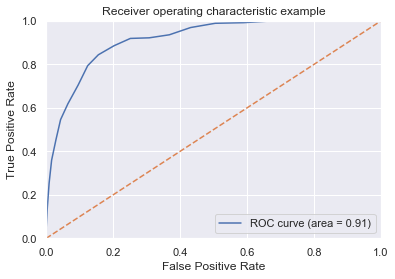

In [644]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [645]:
print("Recall Score:")
print(recall_score(y_test,y_pred_forest))
print("Precision Score:")
print(precision_score(y_test,y_pred_forest))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_forest)

Recall Score:
0.8440111420612814
Precision Score:
0.31962025316455694
Confusion matrix


array([[3496,  645],
       [  56,  303]])

In [646]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.5505932613115663

In [647]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.25348189415041783
Precision Score:
0.7165354330708661
Confusion matrix


array([[4105,   36],
       [ 268,   91]])

In [648]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.5505932613115663

In [649]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.2


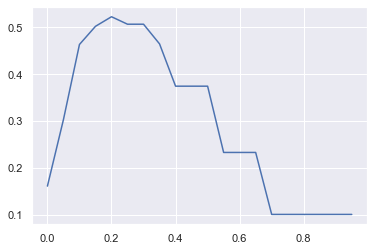

In [650]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [651]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.6183844011142061
Precision Score:
0.4530612244897959
Confusion matrix


array([[3873,  268],
       [ 137,  222]])

## Gradient Boosting

In [652]:
feature_names = X_train.columns
tree = GradientBoostingClassifier(n_estimators=50)  #Setting n_estimator to prevent overfitting
tree_fitted = tree.fit(X_train, y_train) 
scores = cross_val_score(tree, X_train, y_train, cv=5)
y_pred_tree = tree.predict(X_test)
y_pred_prob_tree = tree.predict_proba(X_test)
 
scores = cross_val_score(tree, X_train, y_train, cv=5)
y_pred_tree = tree.predict(X_test)
y_pred_prob_tree = tree.predict_proba(X_test)

In [653]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = tree_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.85 (+/- 0.03)


mechvent                    1.000000
DEATHRATE_CAT__2.0          0.754500
DEATHRATE_CAT__1.0          0.624390
SpO2_Min                    0.605602
urineoutput                 0.542353
                              ...   
INSURANCE_TYPE__Medicare    0.000000
DiasBP_Mean                 0.000000
INSURANCE_TYPE__Private     0.000000
careunit__MICU              0.000000
subject_id                  0.000000
Length: 61, dtype: float64

In [654]:
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability


pred_rew_prob = reweight(y_pred_prob_tree[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_tree[:,1]

AUC:  0.9292374172535128


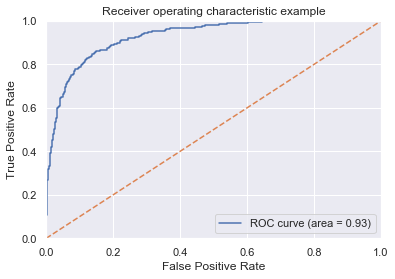

In [655]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [656]:
print("Recall Score:")
print(recall_score(y_test,y_pred_tree))
print("Precision Score:")
print(precision_score(y_test,y_pred_tree))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_tree)

Recall Score:
0.8467966573816156
Precision Score:
0.346636259977195
Confusion matrix


array([[3568,  573],
       [  55,  304]])

In [657]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.630349322124315

In [658]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.31754874651810583
Precision Score:
0.8085106382978723
Confusion matrix


array([[4114,   27],
       [ 245,  114]])

In [659]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.630349322124315

In [660]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.25


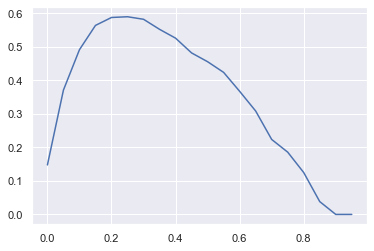

In [661]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [662]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.6100278551532033
Precision Score:
0.5718015665796344
Confusion matrix


array([[3977,  164],
       [ 140,  219]])

## XGBOOST

In [663]:
# feature importance
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1)

xgb_model.fit(X_train,y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)
scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)

In [664]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

importances = xgb_model.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.86 (+/- 0.01)


mechvent                     1.000000
DEATHRATE_CAT__2.0           0.915711
cardiovascular               0.832860
DEATHRATE_CAT__1.0           0.709884
ADMISSION_TYPE__EMERGENCY    0.569324
                               ...   
DEATHRATE_INT_CAT__1.0       0.000000
ADMISSION_TYPE__URGENT       0.000000
INSURANCE_TYPE__Medicaid     0.000000
INSURANCE_TYPE__Self Pay     0.000000
DEATHRATE_INT_CAT__2.0       0.000000
Length: 61, dtype: float32

In [665]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability

pred_rew_prob = reweight(y_pred_prob_xgb[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_xgb[:,1]

AUC:  0.9406236567674704


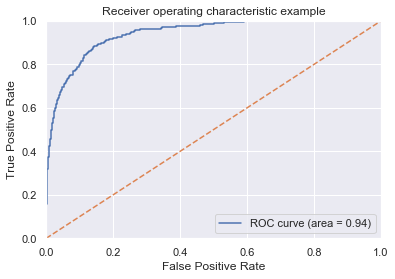

In [666]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [667]:
print("Recall Score:")
print(recall_score(y_test,y_pred_xgb))
print("Precision Score:")
print(precision_score(y_test,y_pred_xgb))
print("Confusion matrix")
cm=confusion_matrix(y_test,y_pred_xgb)

Recall Score:
0.8802228412256268
Precision Score:
0.3511111111111111
Confusion matrix


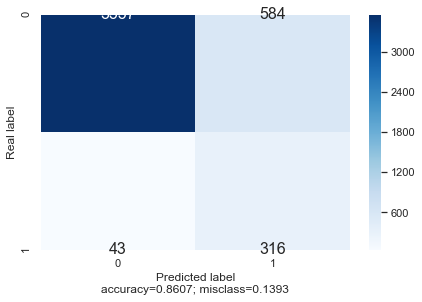

<Figure size 720x504 with 0 Axes>

In [668]:
plot_confusion_matrix(cm,["0", "1"])

In [669]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.6771882558885125

In [670]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.6128133704735376
Precision Score:
0.6376811594202898
Confusion matrix


array([[4016,  125],
       [ 139,  220]])

In [671]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.6771882558885125

In [672]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.55


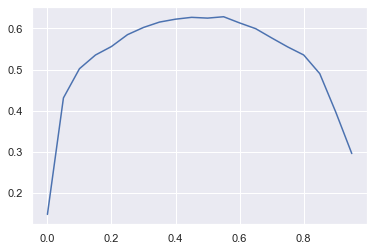

In [673]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [674]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5933147632311978
Precision Score:
0.6677115987460815
Confusion matrix


array([[4035,  106],
       [ 146,  213]])

## SVC

In [710]:
svm_model = SVC(C=10, kernel='linear', probability=True, gamma='scale', random_state=1)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_pred_prob_svm = svm_model.predict_proba(X_test)
scores = cross_val_score(svm_model, X_train, y_train, cv=5)

In [711]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#importances = svm_model.feature_importances_
#important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
#important_features.sort_values(ascending=False)

Accuracy: 0.84 (+/- 0.05)


In [712]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability

pred_rew_prob = reweight(y_pred_prob_svm[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_svm[:,1]

AUC:  0.9191110836064923


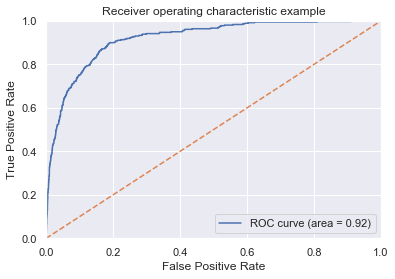

In [713]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [714]:
print("Recall Score:")
print(recall_score(y_test,y_pred_svm))
print("Precision Score:")
print(precision_score(y_test,y_pred_svm))
print("Confusion matrix")
cm=confusion_matrix(y_test,y_pred_svm)

Recall Score:
0.8245125348189415
Precision Score:
0.3337091319052988
Confusion matrix


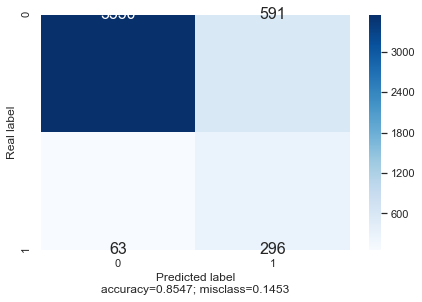

<Figure size 720x504 with 0 Axes>

In [715]:
plot_confusion_matrix(cm,["0", "1"])

In [716]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.5668011631086818

In [717]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.4373259052924791
Precision Score:
0.6382113821138211
Confusion matrix


array([[4052,   89],
       [ 202,  157]])

In [718]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.5668011631086818

In [719]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.25


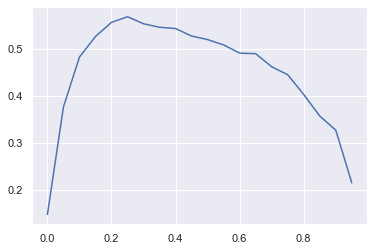

In [720]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [721]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.6323119777158774
Precision Score:
0.5147392290249433
Confusion matrix


array([[3927,  214],
       [ 132,  227]])

## Logistic Regression

In [687]:
from sklearn.linear_model import LogisticRegression

lregr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

# Fiting logistic regression

lregr.fit(X_train,y_train)      

#Predictions
y_pred_log = lregr.predict(X_test)
y_pred_prob_log = lregr.predict_proba(X_test)

In [688]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability

pred_rew_prob = reweight(y_pred_prob_log[:,1], q1, r1) #[i for i in 

# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_log[:,1]

AUC:  0.918901211406554


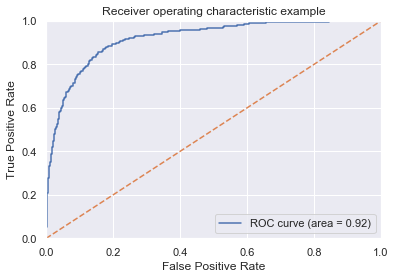

In [689]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [690]:
print("Recall Score:")
print(recall_score(y_test,y_pred_log))
print("Precision Score:")
print(precision_score(y_test,y_pred_log))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_xgb)

Recall Score:
0.83008356545961
Precision Score:
0.33979475484606614
Confusion matrix


array([[3557,  584],
       [  43,  316]])

In [691]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.5805517603110161

In [692]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.49303621169916434
Precision Score:
0.6254416961130742
Confusion matrix


array([[4035,  106],
       [ 182,  177]])

In [693]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.5805517603110161

In [694]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.35000000000000003


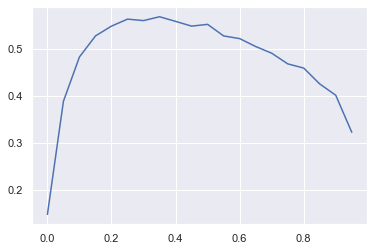

In [695]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [696]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.584958217270195
Precision Score:
0.5511811023622047
Confusion matrix


array([[3970,  171],
       [ 149,  210]])

## Ensemble

In [697]:
def get_models():
    #Generate a library of simple learners
    rf = RandomForestClassifier(n_estimators=20)
    tree = GradientBoostingClassifier(n_estimators=50)
    xgb_mod = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1)
    lr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

    models = {'random forest': rf,
              'gradient boosting': tree,
              'xgboost': xgb_mod,
              'logistic': lr,
              }

    return models

models = get_models()

In [698]:
meta_learner = ExtraTreesClassifier(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7)

In [699]:
# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    verbose=2
)

# Add the base learners and the meta learner
sl.add(list(models.values()), proba=True)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

y_pred_prob_sl = sl.predict_proba(X_test)


Fitting 2 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:07

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [700]:
y_pred_sl = [1 if i>0.5 else 0 for i in y_pred_prob_sl[:,1]]

In [701]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability


pred_rew_prob = reweight(y_pred_prob_sl[:,1], q1, r1) #[i for i in 

# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_sl[:,1]

AUC:  0.9193011121208595


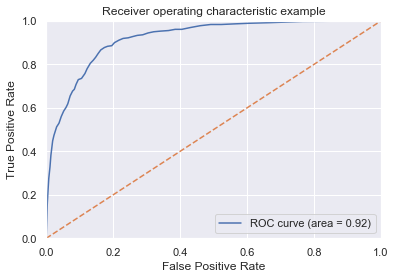

In [702]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [703]:
print("Recall Score:")
print(recall_score(y_test,y_pred_sl))
print("Precision Score:")
print(precision_score(y_test,y_pred_sl))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_sl)

Recall Score:
0.8495821727019499
Precision Score:
0.3220696937697994
Confusion matrix


array([[3499,  642],
       [  54,  305]])

In [704]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.5761846757420641

In [705]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.3816155988857939
Precision Score:
0.7025641025641025
Confusion matrix


array([[4083,   58],
       [ 222,  137]])

In [706]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.5761846757420641

In [707]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.4


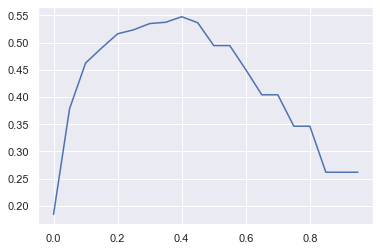

In [708]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [709]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5125348189415042
Precision Score:
0.5878594249201278
Confusion matrix


array([[4012,  129],
       [ 175,  184]])

## Feed-Forward Neural Net

In [478]:
# To be added from FFNN_Mortality_Predictions file once issue with:
# type object 'h5py.h5f.FileID' has no attribute '__reduce_cython__' 
# is fixed

In [479]:
#These lines might be required for the code to run below:
#conda install keras
#conda install h5py=2.8.0

In [722]:
from copy import deepcopy
import sys

from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM, GRU 
from keras.models import model_from_json, Sequential
from keras.optimizers import RMSprop
from keras import optimizers
import numpy as np
from sklearn.model_selection import StratifiedKFold
#import theano


sys.path.append("..\..")
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

from random import choice
from string import ascii_uppercase

import os
from random import choice

In [723]:
import os
import warnings
import sys
from keras.callbacks import Callback
import numpy as np


class EarlyStoppingRestoringWeights(Callback):
    def __init__(self, monitor='val_loss', patience=0, verbose=0, 
                 weight_path = None):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.weight_path = weight_path
        self.best = np.Inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" \
                % (self.monitor), RuntimeWarning)
        sys.stdout.flush()
        if current < self.best:
            self.best = current
            self.model.save_weights(self.weight_path, overwrite=True)
            self.wait = 0
        else:
            if self.wait >= self.patience:
                if self.verbose > 0:
                    print("Epoch %05d: early stopping" % (epoch))
                self.model.stop_training = True
            self.wait += 1

    def on_train_end(self, epoch, logs={}):
        try:
            self.model.load_weights(self.weight_path)
            os.remove(self.weight_path)
        except Exception as exc:
            print ('error while loading and removing weights', str(exc))

In [724]:
class FeedForwardNetwork(object):
    def __init__(self, hidden_dim=10, final_activation='sigmoid', loss='binary_crossentropy',
                 batch_size=40, nb_epoch=100, learning_rate=0.001, validation_split=0.25, patience=20, early_stopping='True_BestWeight', ffn_depth=2,
                 batch_normalization='False'):
        self.hidden_dim = hidden_dim
        self.final_activation = final_activation
        self.loss = loss
        self.batch_size = batch_size
        self.nb_epoch = nb_epoch
        self.learning_rate = learning_rate
        self.validation_split = validation_split
        self.patience = patience
        self.EarlyStopping = early_stopping
        self.type_MMDL = 1
        #self.random_str = ''.join(choice(ascii_uppercase) for i in range(12))
        self.ffn_depth = ffn_depth
        self.batch_normalization = batch_normalization

    # get the i-th (hidden) layer output as the features of input X
    def transform_features(self, X, layers=None):
        pass
 
    def transform(self, X):
        return None

    # sklearn.$anymodel$.fit
    def fit(self, X, y):
        n_features = X.shape[1]
        model = Sequential()

        hidden_dim = self.hidden_dim
        final_activation = self.final_activation
        loss = self.loss
        if hidden_dim is None:
            hidden_dim = 8 * n_features

        model.add(Dense(hidden_dim, input_shape=(n_features, ), activation='sigmoid'))
        model.add(Dropout(0.1))
        for t in range(self.ffn_depth - 1):
            print('layer%d'%t)
            model.add(Dense(hidden_dim, activation='sigmoid'))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation=None))
        if self.batch_normalization == 'True':
            model.add(BatchNormalization())
        model.add(Activation(activation=final_activation))
        self.model = model
        print ('number of parameters: ' + str(self.model.count_params()))
        print ('before compiling')
        self.model.compile(loss=loss, optimizer=RMSprop(lr=self.learning_rate), metrics=['accuracy'])
        print ('before fitting')

        if self.EarlyStopping == 'True_BestWeight':
            self.model.fit(
                x=X, y=y,
                batch_size=self.batch_size, nb_epoch=self.nb_epoch,
                # show_accuracy=True,
                verbose=2, shuffle=False,
                validation_split=self.validation_split,
                #callbacks = [EarlyStopping(patience=10)],
                #callbacks=[EarlyStoppingRestoringWeights(patience=self.patience, weight_path='ES_best_' + str(
                #    self.type_MMDL) + '_' + self.random_str + ' .h5')],
            )

        elif self.EarlyStopping == 'True':
            self.model.fit(
                x=X, y=y,
                batch_size=self.batch_size, nb_epoch=self.nb_epoch,
                # show_accuracy=True,
                verbose=2,
                validation_split=self.validation_split,
                callbacks=[EarlyStopping(patience=self.patience)],
            )

        elif self.EarlyStopping == 'False':
            self.model.fit(
                x=X, y=y,
                batch_size=self.batch_size, nb_epoch=self.nb_epoch,
                # show_accuracy=True,
                verbose=2,
                validation_split=self.validation_split,
            )

        print ('after fitting')
        return self
            
    # get output layer values of input X
    def decision_function(self, X):
        return self.model.predict(X)
        
    # get prediction of input X (compare output value and threshold)
    def predict(self, X):
        if self.loss == 'mean_squared_error':
            return self.model.predict(X)
        else:
            return self.model.predict_classes(X)
        
    # get prediction of input X (compare output value and threshold)
    def predict_proba(self, X):
        #if self.loss == 'mean_squared_error':
            #return self.model.predict(X)
        #else:
        return [self.model.predict_proba(X),1-self.model.predict_proba(X)]

In [725]:
model = FeedForwardNetwork()
model.fit(X_train,y_train)

layer0
number of parameters: 741
before compiling
before fitting


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1530 samples, validate on 510 samples
Epoch 1/100
 - 2s - loss: 0.6582 - accuracy: 0.6098 - val_loss: 0.7601 - val_accuracy: 0.1412
Epoch 2/100
 - 0s - loss: 0.6316 - accuracy: 0.6562 - val_loss: 0.7889 - val_accuracy: 0.1314
Epoch 3/100
 - 0s - loss: 0.6147 - accuracy: 0.6961 - val_loss: 0.8130 - val_accuracy: 0.1490
Epoch 4/100
 - 0s - loss: 0.6047 - accuracy: 0.6928 - val_loss: 0.8322 - val_accuracy: 0.1745
Epoch 5/100
 - 0s - loss: 0.5846 - accuracy: 0.7007 - val_loss: 0.8447 - val_accuracy: 0.2039
Epoch 6/100
 - 0s - loss: 0.5755 - accuracy: 0.7092 - val_loss: 0.8536 - val_accuracy: 0.2196
Epoch 7/100
 - 0s - loss: 0.5647 - accuracy: 0.7203 - val_loss: 0.8608 - val_accuracy: 0.2471
Epoch 8/100
 - 0s - loss: 0.5575 - accuracy: 0.7183 - val_loss: 0.8663 - val_accuracy: 0.2706
Epoch 9/100
 - 0s - loss: 0.5498 - accuracy: 0.7307 - val_loss: 0.8683 - val_accuracy: 0.3020
Epoch 10/100
 - 0s - loss: 0.5464 - accuracy: 0.7314 - val_loss: 0.8691 - val_accuracy: 0.3275
Epoch 11/100

Epoch 87/100
 - 0s - loss: 0.3396 - accuracy: 0.8549 - val_loss: 0.6291 - val_accuracy: 0.7255
Epoch 88/100
 - 0s - loss: 0.3533 - accuracy: 0.8503 - val_loss: 0.6282 - val_accuracy: 0.7275
Epoch 89/100
 - 0s - loss: 0.3410 - accuracy: 0.8608 - val_loss: 0.6243 - val_accuracy: 0.7294
Epoch 90/100
 - 0s - loss: 0.3435 - accuracy: 0.8556 - val_loss: 0.6278 - val_accuracy: 0.7255
Epoch 91/100
 - 0s - loss: 0.3404 - accuracy: 0.8608 - val_loss: 0.6281 - val_accuracy: 0.7255
Epoch 92/100
 - 0s - loss: 0.3381 - accuracy: 0.8614 - val_loss: 0.6282 - val_accuracy: 0.7255
Epoch 93/100
 - 0s - loss: 0.3457 - accuracy: 0.8516 - val_loss: 0.6290 - val_accuracy: 0.7255
Epoch 94/100
 - 0s - loss: 0.3394 - accuracy: 0.8562 - val_loss: 0.6268 - val_accuracy: 0.7255
Epoch 95/100
 - 0s - loss: 0.3342 - accuracy: 0.8595 - val_loss: 0.6272 - val_accuracy: 0.7255
Epoch 96/100
 - 0s - loss: 0.3443 - accuracy: 0.8582 - val_loss: 0.6298 - val_accuracy: 0.7255
Epoch 97/100
 - 0s - loss: 0.3414 - accuracy: 0.85

In [726]:
#Balanced Input
y_pred_NN3 = model.predict(X_test)

print("Recall Score:")
print(recall_score(y_test,y_pred_NN3))
print("Precision Score:")
print(precision_score(y_test,y_pred_NN3))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_NN3)

Recall Score:
0.7437325905292479
Precision Score:
0.3744740532959327
Confusion matrix


array([[3695,  446],
       [  92,  267]])

In [727]:
#from sklearn.metrics import auc, precision_recall_curve

#precision, recall, thresholds = precision_recall_curve(y_test,y_pred_NN3)
#auc(recall, precision)

In [728]:
y_pred_NN3_proba = model.predict_proba(X_test)

In [729]:
# rearrange output of the model to feed the reweighting function
a=y_pred_NN3_proba[0]
b=y_pred_NN3_proba[1]
y_pred_NN3_proba2=np.concatenate((a, b),axis=1)

In [730]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability

pred_rew_prob = reweight(y_pred_NN3_proba2[:,0], q1, r1) # Please not here the class probabilities are 1 and 0

# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_NN3_proba2[:,0]

In [731]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.6058519596163862

In [732]:
precision, recall, thresholds = precision_recall_curve(y_test,pred_rew_prob)
auc(recall, precision)

0.6058519596163862

In [733]:
# Benchmark XGB: 0.557

In [491]:
# FFNN: 0.5598 

# self, hidden_dim=10, final_activation='sigmoid', loss='binary_crossentropy',
#                 batch_size=40, nb_epoch=100, learning_rate=0.001, validation_split=0.25, patience=20, early_stopping='True_BestWeight', ffn_depth=2,
 #                batch_normalization='False'

AUC:  0.9109499474983166


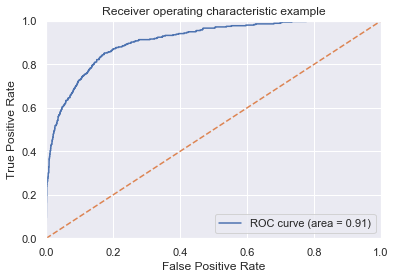

In [734]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [108]:
from sklearn.model_selection import GridSearchCV

MyXGB = xgb.XGBClassifier() #objective='reg:squarederror'
parameters = {'nthread':[3], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [90]}

grid_knn_acc = GridSearchCV(MyXGB, param_grid = parameters, scoring = 'r2', cv=5, refit=True,n_jobs=3)
grid_knn_acc.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=3,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_w

In [109]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
                                                  max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1,seed=27), param_grid = param_test1, 
                                                  scoring='roc_auc',n_jobs=2,cv=5)
gsearch1.fit(X_train,y_train)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, retu

In [110]:
main_df2 = pd.read_csv('main_df2.csv')